FreeGS tutorial
============

Getting started with toroidal equilibria and solving the Grad-Shafranov equation


In [14]:
import numpy as np

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

## Toroidal currents

The magnetic field due to a toroidal wire is calculated using Green's functions
https://github.com/freegs-plasma/freegs/blob/master/freegs/gradshafranov.py#L272

These are written in terms of elliptic functions of the first and second kind

**Note** Some care is needed because there are different definitions (e.g. if arg is squared)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipk.html
https://mathworld.wolfram.com/EllipticIntegraloftheFirstKind.html

First kind:
$K(m) = \int_0^{\pi/2}\frac{1}{\sqrt{1 - m \sin^2\left(t\right)}}dt$

Second kind:
$E(m) = \int_0^{\pi/2}\sqrt{1 - m \sin^2\left(t\right)}dt$

Poloidal flux at $(R, Z)$ due to unit current at $(R_c, Z_c)$ is the current in the coil $I_c$ times the Green's function:

$\psi\left(R, Z; R_c, Z_c\right) = I_c G\left(R, Z; R_c, Z_c\right)$

with Green's function given by:
$G\left(R, Z; R_c, Z_c\right) = \frac{\mu_0}{2\pi} \sqrt{RR_c}\left[(2 - k^2)K\left(k^2\right) - 2E\left(k^2\right)\right] / k$
where
$k^2 = 4RR_c / \left[\left(R + R_c\right)^2 + \left(Z - Z_c\right)^2\right]$

Text(0, 0.5, 'Height Z [m]')

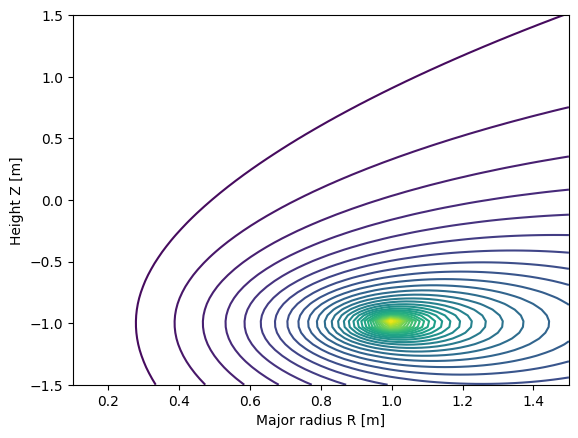

In [16]:
from freegs.coil import Coil

coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA

# Make a 2D grid of R, Z values
# Note: Number of cells 65 = 2^n + 1 is useful later
R, Z = np.meshgrid(np.linspace(0.1, 1.5, 65), np.linspace(-1.5, 1.5, 65), indexing='ij')

# Calculate poloidal flux psi due to coil:
psi = coil_1.psi(R, Z)

plt.contour(R, Z, psi, 40)
plt.xlabel("Major radius R [m]")
plt.ylabel("Height Z [m]")

It can be (initially) easier to visualise what the magnetic field looks like rather than the flux

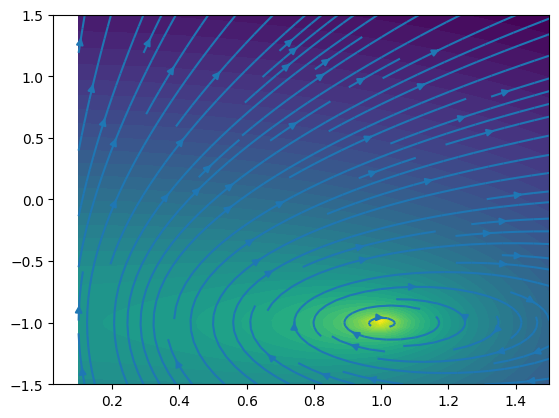

In [17]:
# Radial component of the magnetic field
B_R = coil_1.Br(R, Z)
# Vertical component
B_Z = coil_1.Bz(R, Z)

# Poloidal field magnitude
B_p = np.sqrt(B_R**2 + B_Z**2)

plt.contourf(R, Z, np.log(B_p), 50)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

# Vertical magnetic field

Combining two coils with current in the same direction produces a vertical magnetic field
(A Helmholtz coil)

This is used for **radial** plasma position control

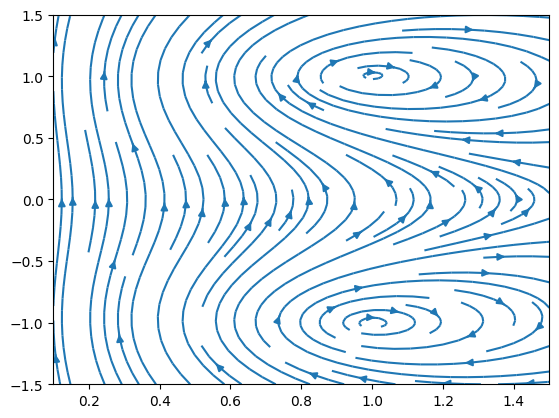

In [18]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = 1e3)  # R = 1m, Z = +1m, current = 1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

# Radial magnetic field

Coils with opposite currents produces a radial magnetic field.

This is used for **vertical** plasma position control

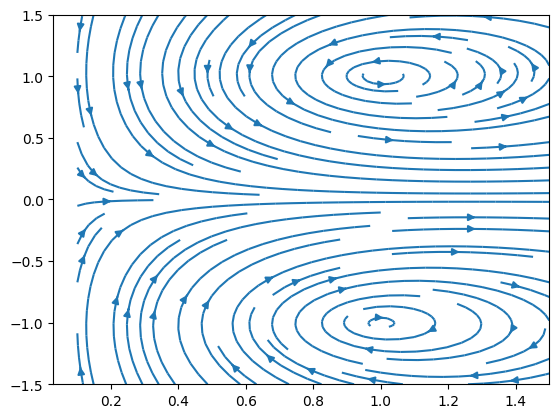

In [19]:
coil_1 = Coil(1.0, -1.0, current = 1e3)  # R = 1m, Z = -1m, current = 1kA
coil_2 = Coil(1.0, 1.0, current = -1e3)  # R = 1m, Z = +1m, current = -1kA

B_R = coil_1.Br(R, Z) + coil_2.Br(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
B_Z = coil_1.Bz(R, Z) + coil_2.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

# Circuits

Most tokamaks do not have a separate power supply for each coil. Instead they are often wired in pairs, either in series or anti-series.

FreeGS defines a `Circuit` class to group coils together

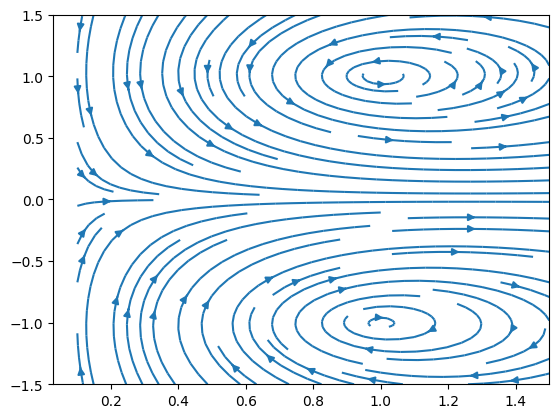

In [20]:
from freegs.machine import Circuit

circuit_1 = Circuit([("P1L", Coil(1.0, -1.0), 1.0),
                    ("P1U", Coil(1.0, 1.0), -1.0)], # Negative so anti-series
                   current = 1e3) # 1kA in this circuit
B_R = circuit_1.Br(R, Z)
B_Z = circuit_1.Bz(R, Z)
plt.streamplot(R.T, Z.T, B_R.T, B_Z.T)

# Change of topic: Plasma current

The plasma carries a current in the toroidal and poloidal direction. The toroidal plasma current generates a poloidal magnetic field that adds to the field from the poloidal field (PF) coils.

The principle is the same as for the coils, except we're integrating a current density over the plasma: The poloidal flux at $(R, Z)$ is 

$\psi_{plasma}\left(R, Z\right) = \int_{R,Z}J_\phi\left(R', Z'\right) G\left(R, Z; R', Z'\right) dR'dZ'$

where $J_\phi\left(R, Z\right)$ is the toroidal current density (in A/m$^2$) in the plasma.

## Computationally efficient methods

Unfortunately the brute-force way to calculate $\psi_{plasma}\left(R, Z\right)$ using the above integral is very slow. For an $N\times N$ mesh the time to calculate a $\psi$ at every point goes like $N^4$.
(Note that techniques like fast multipole can improve this, but would be quite complex to implement).

Instead we start from the differential form and solve a Laplacian-like equation for $\psi$

$\Delta^*\psi = R^2 \nabla\cdot\frac{1}{R^2}\nabla\psi = -\mu_0 R J_\phi$

Multi-grid solvers can be very effective for this kind of problem, with run-time scaling linear with the number of unknowns. 
**Note** Simpler but theoretically worse scaling methods can be faster for small mesh sizes $N$.

To do this we need to:
- Generate a matrix that represents the $\Delta^*$ operator on each mesh resolution: https://github.com/freegs-plasma/freegs/blob/master/freegs/gradshafranov.py#L153
- If using multiple resolution levels, generate a matrix for each level: https://github.com/freegs-plasma/freegs/blob/master/freegs/multigrid.py#L139
- At the coarsest level create a direct solver (using LU decomposition in SciPy): https://github.com/freegs-plasma/freegs/blob/master/freegs/multigrid.py#L35

In [21]:
# Define a toroidal current density
J_tor = np.exp(-(R - 0.5)**2 - Z**2) * 1e3  # In A/m^2

# Matrix generator, giving range of R and Z we're going to solve over
from freegs.gradshafranov import GSsparse
generator = GSsparse(np.amin(R), np.amax(R), np.amin(Z), np.amax(Z))

# For example a 3x3 mesh. 2nd order method has 5-point stencil
np.set_printoptions(precision=2)
generator(3,3).toarray()

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  2.93,  0.  ,  0.44, -4.97,  0.44,  0.  ,  1.15,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

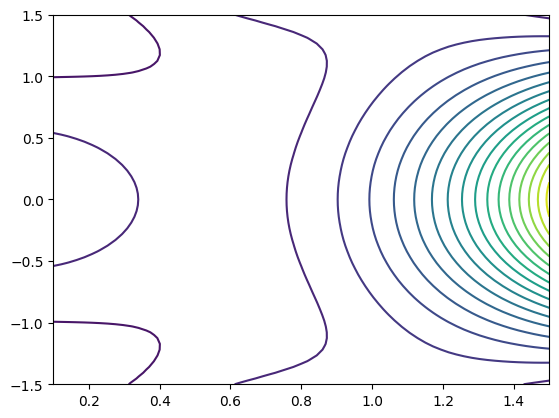

In [22]:
# Generate a matrix for our array
nx, ny = R.shape
A = generator(nx, ny)

# LU factorize (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.factorized.html)
from scipy.sparse.linalg import factorized
solver = factorized(A.tocsc())

# Solve for psi from J_tor
mu0 = 4e-7 * np.pi
psi = solver((mu0 * R * J_tor).flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

The boundaries look wrong (they *are* wrong): In the 3x3 matrix above the boundary cells have `1` on the diagonal. That means the boundary values of $\psi$ are set to the boundary cells of the RHS, i.e. $\mu_0 R J_\phi$.

One approximation is to set boundaries to conducting: $\psi = $ constant on the boundary

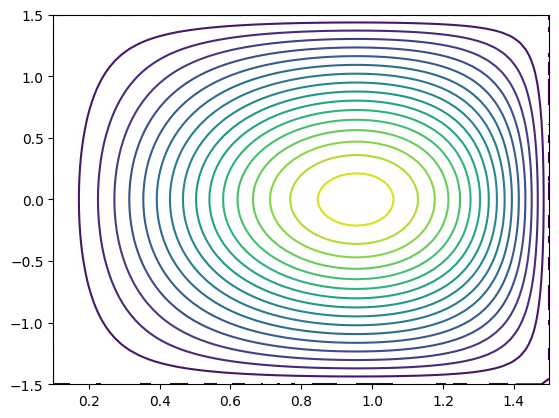

In [23]:
rhs = -mu0 * R * J_tor
# Set all boundaries of psi to zero:
rhs[0,:] = rhs[-1,:] = rhs[:,0] = rhs[:,-1] = 0

# Re-solve
psi = solver(rhs.flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

# Free boundary solutions

To obtain the boundary conditions for a "free" boundary, one way is to use the brute-force approach (integrate Green's functions) along the boundary.
https://github.com/freegs-plasma/freegs/blob/master/freegs/boundary.py#L50

For each point on the boundary we perform an integral over the 2D $(R,Z)$ domain.

Romberg integration is an accurate method, but needs $2^n + 1$ points. Hence grid sizes like 33, 65, 129.

Note: 
- This is more efficient than a full brute force, because integrals are only for the boundary points rather than every point in the domain
- A more effient method is von Hagenow's method. That replaces 2D integrals with a calculation of normal derivatives, and a 1D integral over the boundary. The default method in FreeGS: https://github.com/freegs-plasma/freegs/blob/master/freegs/boundary.py#L102

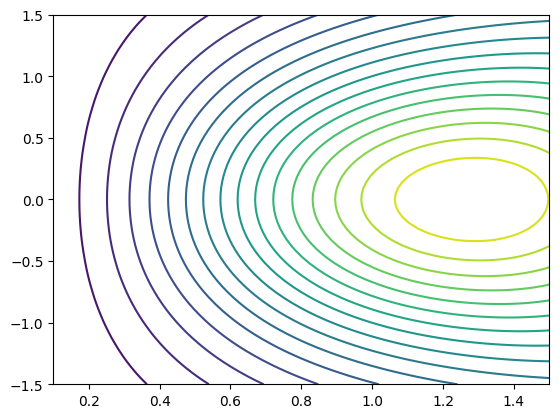

In [24]:
rhs = -mu0 * R * J_tor

# List of indices on the boundary
bndry_indices = np.concatenate(
    [
        [(x, 0) for x in range(nx)],
        [(x, ny - 1) for x in range(nx)],
        [(0, y) for y in range(ny)],
        [(nx - 1, y) for y in range(ny)],
    ]
)

from freegs.gradshafranov import Greens
from scipy.integrate import romb

dR = R[1, 0] - R[0, 0]
dZ = Z[0, 1] - Z[0, 0]

for x, y in bndry_indices:
    # Calculate the response of the boundary point
    # to each cell in the plasma domain
    greenfunc = Greens(R, Z, R[x, y], Z[x, y])

    # Prevent infinity/nan by removing (x,y) point
    greenfunc[x, y] = 0.0
    
    # Integrate over the domain
    rhs[x, y] = romb(romb(greenfunc * J_tor)) * dR * dZ
    
# Re-solve
psi = solver(rhs.flatten()).reshape(R.shape)

# Plot contours of psi
plt.contour(R, Z, psi, 20)

## Radial motion

Plotting the toroidal current $J_\phi$ on top of the contours of $\psi$ we will see that they don't line up.
The poloidal flux $\psi$ is shifted radially outwards.

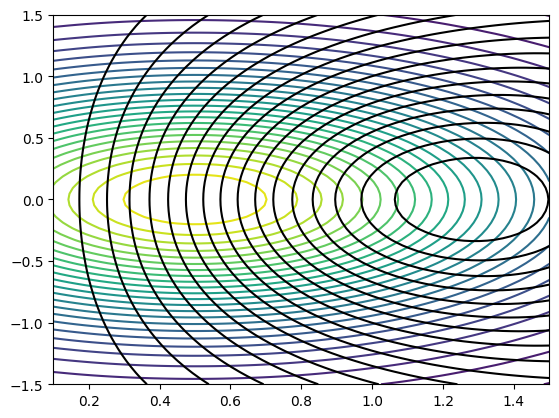

In [25]:
plt.contour(R, Z, J_tor, 30)  # Coloured lines are toroidal current
plt.contour(R, Z, psi, 20, colors='k')  # Black contours are poloidal flux

In a static plasma the current flows on flux surfaces (cross-field currents = torques). If we now try to update the solution, putting our toroidal current on flux surfaces, the plasma will have moved outwards!

**A toroidal current-carrying plasma will expand radially outwards**

This is seen in toroidal force balance as the **Hoop force** and **Tire force**. It appears in free-boundary Grad-Shafranov solvers as a systematic shift between iterations, since here we are not considering plasma inertia.


# Radial force balance

The solution is to add a vertical magnetic field, providing an inward force. We can vary the current in the coil to find the coil current that keeps the plasma in (approximately) the initial location.

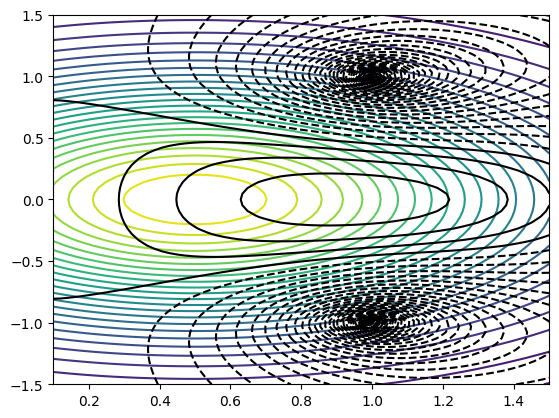

In [26]:
circuit_1 = Circuit([("P1L", Coil(1.0, -1.0), 1.0),
                    ("P1U", Coil(1.0, 1.0), 1.0)], # In series => Vertical field
                   current = -1e3) # 1kA in this circuit

# Add plasma and coil psi
total_psi = psi + circuit_1.psi(R, Z)

# Plot toroidal current and total psi
plt.contour(R, Z, J_tor, 30)  # Coloured lines are toroidal current
plt.contour(R, Z, total_psi, 40, colors='k')  # Black contours are poloidal flux

This is what the control system in a free-boundary Grad-Shafranov solver does!

Given a set of coils:
- The user may fix some currents
- Constraints are provided by the user: Locations of X-points ($B_R = B_Z = 0$) and iso-flux i.e. two points with the same value of $\psi$
- An automatic control system tries to find combinations of coil currents that best match the constraints

This is typically an ill-posed problem, either too many constraints or too few. 
- Regularisation needed
- Typically also want to minimise coil currents

**Note**: The method used in FreeGS minimizes the *change* in coil current between iterations, not the coil current. The coil currents it finds **may not be a global optimum**: https://github.com/freegs-plasma/freegs/blob/master/freegs/control.py#L68
- Other control methods may be used in practice to find global optimum

# Example of setting up a machine

1. A definition of the locations of the poloidal field coils, and how they are wired together, for example connected in series to the same power supplies. This is specific to the machine.
2. Plasma profiles of pressure and current, p(psi) and f(psi), together with global contraints such as total plasma current, which indirectly specify the size of the plasma.
3. A control system which sets the shape and location of the plasma. Like a real plasma, feedback control is needed to stabilise vertical and radial motion in free-boundary Grad-Shafranov solvers.

In [8]:
# Step 1: Specify the locations of the coils, and the domain you want to solve over

from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.1, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=65, ny=65)        # Number of grid points

In [9]:
# Step 2: Specify the profiles of pressure and f=R*Bt. 
# Currently quite simple functions are supported

from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(eq,  # Equilibrium
                            3e3, # Plasma pressure on axis [Pascals]
                            7e5, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [10]:
# Step 3: Specify the control system and feedback variables.
# The control system adjusts the currents in the poloidal field coils
# to produce X-points in the desired locations, and ensure that the desired
# pairs of locations have the same poloidal flux.

from freegs import control

xpoints = [(0.7, -1.1),   # (R,Z) locations of X-points
           (0.7, 1.1)]

# Contstrain these pairs of (R,Z, R,Z) locations to have the same poloidal flux
# This is needed for radial and vertical position control of the plasma.
isoflux = [(0.7,-1.1, 1.45, 0.0)   # Lower X-point, Outboard midplane
           ,(0.7,1.1, 1.45, 0.0)   # Upper X-point, Outboard midplane
          ]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

In [11]:
# With these three components (coils, profiles and constraints), solve the nonlinear
# system with a Picard iteration. This modifies the "eq" object.

from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

In [12]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 7.000000e+05 Amps


In [13]:
tokamak.printCurrents()

P2U : Coil(R=0.49, Z=1.76, current=15795.6, turns=1, control=True)
P2L : Coil(R=0.49, Z=-1.76, current=15799.2, turns=1, control=True)
P3U : Coil(R=1.1, Z=1.1, current=20671.8, turns=1, control=True)
P3L : Coil(R=1.1, Z=-1.1, current=20661.2, turns=1, control=True)
P4U : Coil(R=1.51, Z=1.095, current=-35507.5, turns=1, control=True)
P4L : Coil(R=1.51, Z=-1.095, current=-35539.5, turns=1, control=True)
P5U : Coil(R=1.66, Z=0.52, current=-147901.0, turns=1, control=True)
P5L : Coil(R=1.66, Z=-0.52, current=-147953.4, turns=1, control=True)
P6U : Coil(R=1.5, Z=0.9, current=-62391.2, turns=1, control=True)
P6L : Coil(R=1.5, Z=-0.9, current=-62304.6, turns=1, control=True)
P1 : Solenoid(Rs=0.15, Zsmin=-1.4, Zsmax=1.4, current=-90174.89004516602, Ns=100, control=True)


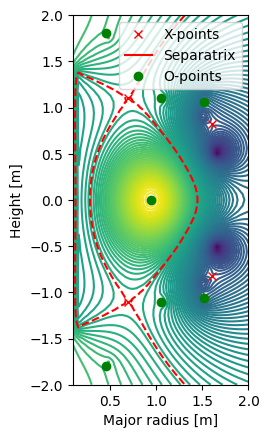

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [33]:
from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)

Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quite quickly finds a new solution.

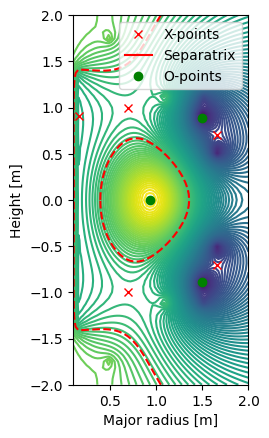

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [34]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)

In [35]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)    # Constraint function to set coil currents

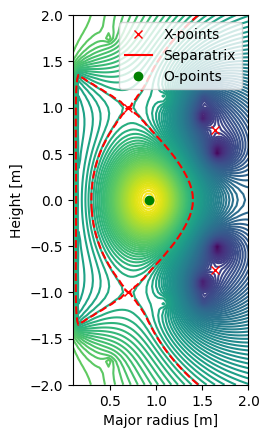

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [36]:
plotEquilibrium(eq)